# Goodman High Throughput Spectrograph Data Reduction Tools


Author: Simón Torres

Date:  January 22, 2021

GitHub: [simontorres](https://github.com/simontorres)


# Presentation Overview

- Goodman High Throughput Spectrograph Overview
- Goodman Spectroscopic Pipeline
- Web App
- Next steps


## Other Relevant work

### Goodman Focus

In Cesar's words:

>  This capability was key for implementing fully automated afternoon calibrations into 
>  the OSM (focus for each setup, biases and dome flats).


[![Goodman Focus Calculator](./img/focus_calculator_1.png)](https://github.com/soar-telescope/goodman_focus)

### Goodman Lamps
[![Reference Lamp Library](./img/reference_lamp_library_1.png)](https://goodman.readthedocs.io/projects/lamps/en/latest/)

# Goodman HTS overview

[SOAR's offical Site  for Goodman HTS](http://www.ctio.noao.edu/soar/content/goodman-high-throughput-spectrograph)


## The Instrument

Is an _imaging spectrograph_ with a wide range of spectral resolutions in the range between 320 to 850 nm. Designed to minimize light lost.

![Spectroscopic Modes](./img/spectroscopic_modes_1.png)

Images from [Clemens et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004SPIE.5492..3)

![Mechanical Structure](./img/estructura-goodman.png)

![Ensamblado](./img/instrument-assembled.png)

![Spectral Range](./img/Visible-spectrum.jpg)
Credits: Unknown



## Basic Spectroscopy Concepts

Spectroscopy is a very versatile observation technique that allows to study chemical composition, temperature, radial velocity or even identify chemical processes.

![espectroscopia](./img/spectroscopy.png)
![espectroscopia](./img/spectroscopy-colors.jpg)

## Data Samples

The raw data is basically images. To get a detailed idea of the full reduction process please review [this notebook](https://nbviewer.jupyter.org/github/simontorres/general_documentation/blob/master/jupyter-notebooks/pipeline_development/Transition_to_live_reduction.ipynb)

In [17]:
import os
import numpy as np

from astropy.visualization import ZScaleInterval
from ccdproc import CCDData
from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(ccd, xlabel='', ylabel='', title=''):
    fig, ax = plt.subplots(figsize=(16,9))
    
    scale = ZScaleInterval()
    
    z1, z2 = scale.get_limits(ccd.data)
        
    img = ax.imshow(ccd.data, clim=(z1, z2), cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    divider = make_axes_locatable(ax)

    cax = divider.append_axes('right', size="3%", pad=0.1)
    plt.colorbar(img, cax=cax)



### Spectroscopic data

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


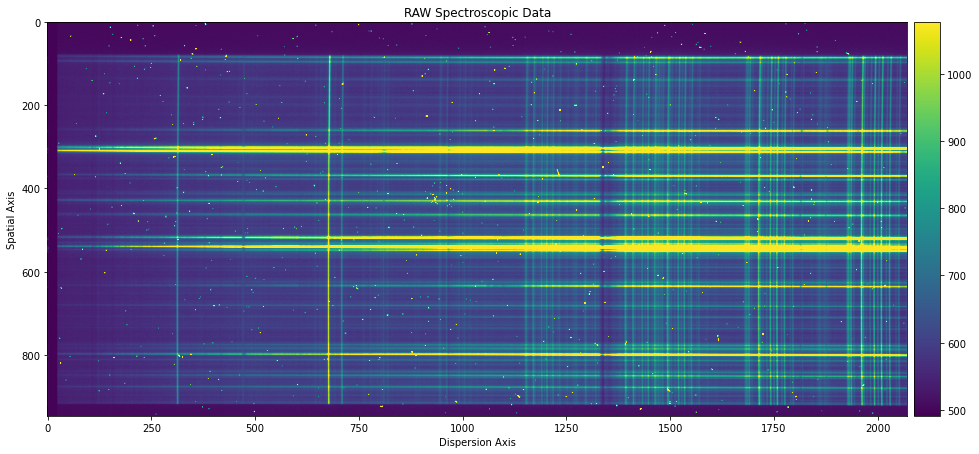

In [14]:
sample_file = '0154_OGLE-2019-BLG-1103-07-08-2019.fits'
full_path = os.path.join(os.getcwd(), 'fits', sample_file)

ccd = CCDData.read(full_path, unit='adu')

plot_image(ccd=ccd, xlabel='Dispersion Axis', ylabel='Spatial Axis', title='RAW Spectroscopic Data')

### Imaging data

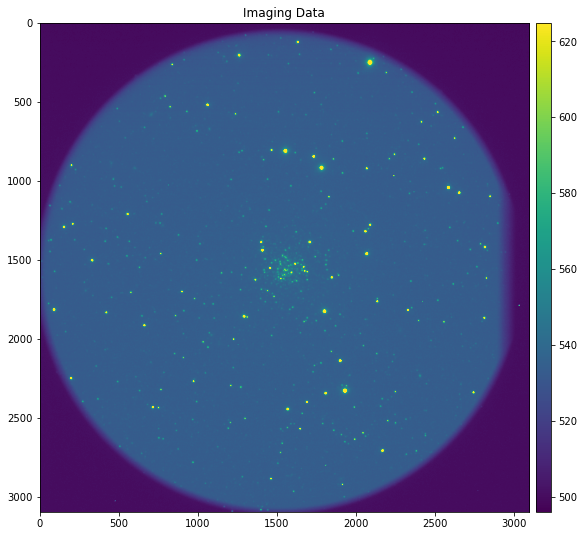

In [15]:
imaging_sample_file = '0238_SO2019B-019.fits'
full_path = os.path.join(os.getcwd(), 'fits', imaging_sample_file)

ccd_img = CCDData.read(full_path, unit='adu')

plot_image(ccd=ccd_img, title="Imaging Data")

# Goodman Pipeline

A python package to produce fully wavelength-calibrated 1D spectra. Initially planned to run in our servers but it can be also installed by anyone.

Go to [documentation in ReadTheDocs](https://goodman.readthedocs.io/en/latest/index.html)


![Goodman Pipeline](https://github.com/soar-telescope/goodman_pipeline/workflows/Goodman%20Pipeline/badge.svg?branch=master)


## Authors

* Simón Torres, Cesar Briceño, PhD., Bruno Quint, PhD., David Sanmartim,PhD. SOAR Telescope, La Serena, Chile.
  - e-mail: simon.torres@noirlab.edu or goodman-pipeline@ctio.noao.edu
  - github: simontorres
  
  
## Motivation

- The Goodman Spectrograph is SOAR's _workhorse_. In use ~ 65% of the available time.
- SOAR Telescope will become an important follow up facility when Vera Rubin Observatory is online.
- Inexistent coordinated effort to have a single tool
  - But even with one there are still problems (User inputs)
- Astropy was and is the promise to replace IRAF.


## Goals

- Easy to install and use
- Fast
- Well Documented
- Meet industry standards (styles, packaging)
- Produce science-ready products
- 100% Python
  - Use as much Astropy packages as possible
- Contribute our experience to the community
  
## Other Features

- Reusable code
- High test coverage
- Build and Tested daily in a Jenkins Server
- Publicly Available on [GitHub](https://github.com/soar-telescope/goodman_pipeline)


# Web App

http://soarvm2.ctio.noao.edu/gsp

It was also considered the option to make a native aplication (GUI with Qt) that would run in a VNC Server.

## Motivation

- The common method for providing remote users with access was through _VPN protected_ VNC Server
  - credentials were not personalized
  - they didn't change in years
- Most users were remote
- Web technology well advanced and easy to reach
- AEON (though not in the project requirements)

Also..

- ADASS XXVIII (2018) [Tutorials](https://adass2018.astro.umd.edu/tutorial.html)
  - Creating Astronomical Web Applications From Scratch: Introduction to modern full-stack MEAN development
  - Working with the Hubble Space Telescope Public Data on Amazon Web Services

## API: Definition and Concepts



## Components

Built using a Microservices Architecture and runs in a containerized environment using Docker containers and deployed using docker compose.

See ADASS XXX (2020) [Poster & Video](https://schedule.adass2020.es/adass2020/talk/CCA7YF/)

### Trigger

Uses the library `pyinotify` to monitor filesystem events

```
   Pyinotify is a Python module for monitoring filesystems changes.
   Pyinotify relies on a Linux Kernel feature (merged in kernel 2.6.13) called inotify. 
   inotify is an event-driven notifier, its notifications are exported from kernel space 
   to user space through three system calls. pyinotify binds these system calls and provides 
   an implementation on top of them offering a generic and abstract way to manipulate 
   those functionalities.
```
Also uses `Celery` for queueing the tasks.

- Copies the file to a very clearly defined folder structure
  - Both human and computer comprehensive
- Triggers the appropriate reduction process depending on the type of file


### Database

Uses [PostgreSQL](https://www.postgresql.org/)

Only stores file location and metadata.

### Private API

Is more of a _Remote Procedure Call_ implemented as a Web API using _Django_ and _Django REST Framework_.

Implements the `goodman_pipeline` package functionality as API endpoints.

![Private API](./img/private_api_1.png)

It does not require authentication because it only runs _inside_ the docker network, therefore not exposed publicly. Having this as an independent component leaves room for adding more instruments.


### Public API

Authenticated REST(-ish*) API that acts as a wrapper and proxy to the private API

 - Receives simple requests
 - Composes the more complicated ones for the private API

For example:

(You would need to make a `GET` request to `/api/files/` and the you will have the file IDs)

`POST: {public-host}/api/files/spectrum/calibrate/wavelength/`

```json
   {
      "file_id": "898",
      "comparison_lamp_id": "901"
    }
```

Will get the data from the database for files with id "898" and "901" and make the following request to the private host. If `comparison_lamp_id` is not provided it will search the database for compatible lamps and pick the newest.


`POST: {private-host}/api/spectrum/calibrate/wavelength/`

```json
   {
        "file_full_path": "/pipeline/data/20201126/REDUCED/ecfzst_0351_Orion-Burst_26-11-2020_430.fits",
        "reference_lamps": [
            "/pipeline/data/20201126/REDUCED/ecfzst_0354_Orion-Burst_26-11-2020_comp_430.fits"
        ],
        "settings": {
            "id": 20,
            "ignore_bias": false,
            "min_bias_files": 10,
            "ignore_flats": false,
            "min_flat_files": 10,
            "cosmic_ray_rejection": "dcr",
            "flat_normalization": "simple",
            "flat_normalization_order": 15,
            "saturation_threshold": 1,
            "extraction_type": "fractional",
            "background_threshold": 1,
            "correlation_tolerance": 15,
            "target_fit_model": "moffat",
            "max_targets": 3,
            "technique": "Spectroscopy",
            "proposal": 20
        }
    }
```

Full response from public API. Includes initial request, what was requested to the private API and what was the response from it.

```json
{
  "api_version": "0.1.0.dev1",
  "username": "storres",
  "request_data": {
    "file_id": "898",
    "comparison_lamp_id": "902"
  },
  "error": "",
  "api_request": {
    "file_full_path": "/pipeline/data/20201126/REDUCED/ecfzst_0351_Orion-Burst_26-11-2020_430.fits",
    "reference_lamps": [
      "/pipeline/data/20201126/REDUCED/ecfzst_0354_Orion-Burst_26-11-2020_comp_430.fits"
    ],
    "settings": {
      "id": 20,
      "ignore_bias": false,
      "min_bias_files": 10,
      "ignore_flats": false,
      "min_flat_files": 10,
      "cosmic_ray_rejection": "dcr",
      "flat_normalization": "simple",
      "flat_normalization_order": 15,
      "saturation_threshold": 1,
      "extraction_type": "fractional",
      "background_threshold": 1,
      "correlation_tolerance": 15,
      "target_fit_model": "moffat",
      "max_targets": 3,
      "technique": "Spectroscopy",
      "proposal": 20
    }
  },
  "api_response": {
    "api_version": "0.1.0.dev1",
    "pipeline_version": "1.3.2",
    "request_data": {
      "file_full_path": "/pipeline/data/20201126/REDUCED/ecfzst_0351_Orion-Burst_26-11-2020_430.fits",
      "reference_lamps": [
        "/pipeline/data/20201126/REDUCED/ecfzst_0354_Orion-Burst_26-11-2020_comp_430.fits"
      ],
      "settings": {
        "id": 20,
        "ignore_bias": false,
        "min_bias_files": 10,
        "ignore_flats": false,
        "min_flat_files": 10,
        "cosmic_ray_rejection": "dcr",
        "flat_normalization": "simple",
        "flat_normalization_order": 15,
        "saturation_threshold": 1,
        "extraction_type": "fractional",
        "background_threshold": 1,
        "correlation_tolerance": 15,
        "target_fit_model": "moffat",
        "max_targets": 3,
        "technique": "Spectroscopy",
        "proposal": 20
      }
    },
    "technique": "Spectroscopy",
    "solution": {
      "wavelength_solution": [
        {
          "solution_info": {
            "rms_error": "0.6524",
            "npoints": "53",
            "nrjections": "10"
          },
          "file_name": "/pipeline/data/20201126/REDUCED/wecfzst_0351_Orion-Burst_26-11-2020_430_ws_1.fits",
          "reference_lamp": "/pipeline/data/20201126/REDUCED/wecfzst_0354_Orion-Burst_26-11-2020_comp_430_ws_1.fits"
        }
      ],
      "warning": "",
      "error": ""
    },
    "error": ""
  }
}
```

`* I use the definition of REST as a guide and don't expect to meet all its requirements` 

### Frontend

Was made in Django as well to take advantage of Django security features.

It works well, but...

- It can slow things down because on every little change the full page has to be reload
  - Relevant for interactive viewing where visualization data can be heavy
- Server side pagination
- It is coupled with the Public API _service_
- For authentication uses Django Sessions


#### Screenshots

![webapp](./img/webapp_1.png)
![webapp](./img/webapp_2.png)
![webapp](./img/webapp_3.png)
![webapp](./img/webapp_4.png)
![webapp](./img/webapp_5.png)

## Why Django

 - Is Python
 - Abstracts database management
 - Already comes with security in mind
 - Is well documented
 - has lots of _plugins_




  
  
## Benefits

- Access Control
  - Principle of minimum privileges
  - Each user has its own credentials (despite how obvious this might sound)
  - Automated password creation, renewal & recovery
  - Password validators
- Web apps are inherently cross-platform








# Future

_"Everything is for sale"_

## Observation Schedule Manager Integration

So far we have worked in _coordinated mode_ and now we are discussing and documenting how to share resources such as database, disk space and identify duplicated efforts.


## REACT Frontend

- Decouple from Public API
- Faster reload time
- Higher Availability
- Switch from Bootstrap 4 to Materialize
  - Feature Discovery
- Switch from Sessions to Json Web Token

## Last but not least

- Web App
  - Level up Documentation and CI
  - Automate deployment process
  - SSL Encryption
  - Cacheing optmization
  - NOAO Archive integration
  - AWS
- Personal
  - Focus on backend
  - Contribute to the Astropy Community (`specreduce`)
  - Get into the [TOM](https://lco.global/tomtoolkit/) bussiness
